In [37]:
# import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from scipy import stats
from datetime import datetime
from sklearn.cluster import KMeans
from nltk import *
# Only need if package not found
#nltk.download('punkt')
#nltk.download("averaged_perceptron_tagger")
#nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib as mpl
import matplotlib.cm as cm
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.max_columns', 30)

In [38]:
# Load data and Save as dataframe format
df = pd.read_excel('Online Retail.xlsx')

In [39]:
# Remove the duplicates
df = df.drop_duplicates()
print ("Dateframe Dimension after drop duplicates:", df.shape)

Dateframe Dimension after drop duplicates: (536641, 8)


In [40]:
# Remove outlier in the data (abnormal Q'ty and unitprice)
df = df[ (np.abs(stats.zscore(df.Quantity)) <= 3) & (np.abs(stats.zscore(df.Quantity)) <= 3)]
print ("Dateframe Dimension after drop outliers:", df.shape)

Dateframe Dimension after drop outliers: (536298, 8)


In [41]:
# Remove the Quantity < 0 and Uniprice = 0
df = df[ (df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print ("Dateframe Dimension after drop meaningless order:", df.shape)

Dateframe Dimension after drop meaningless order: (524643, 8)


In [42]:
# Drop NaN value
df = df.dropna()
df['CustomerID']= df['CustomerID'].astype(str)
print ("Dateframe Dimension after drop NaN:", df.shape)

Dateframe Dimension after drop NaN: (392460, 8)


In [43]:
# Separate InvoiceDate into Date and Time
df['Date'] = [d.date() for d in df['InvoiceDate']]
df['Time'] = [d.time() for d in df['InvoiceDate']]
# drop InvoiceDate Column
df = df.drop(columns=['InvoiceDate'])
display(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Date', 'Time'],
      dtype='object')

In [44]:
#Create "Amount" attrivutes, which is Q'ty * Unit price
df['Amount'] = df['Quantity'] * df['UnitPrice']
print ("Dateframe Dimension after adding 'Amount':", df.shape)

Dateframe Dimension after adding 'Amount': (392460, 10)


In [45]:
# Create Holiday Label based on date
# Load uk holidays.csv as dataframe
uk_holiday_df = pd.read_csv('UK Bank Holidays.csv')
uk_holiday_df['Date'] = pd.to_datetime(uk_holiday_df['Date'])
# Refine df for only Name and Date
uk_holiday_df = uk_holiday_df[['Date','Name']]
mask = (uk_holiday_df['Date'] > '2010-12-01') & (uk_holiday_df['Date'] <= '2011-12-09')
uk_holiday_df = uk_holiday_df.loc[mask]
uk_holiday_df['Date'] = [d.date() for d in uk_holiday_df['Date']]
# Create Column 'Holiday'
holiday_date = uk_holiday_df['Date'].tolist()
holiday_name = uk_holiday_df['Name'].tolist()
i = 0
days = 7 # the days count for holiday sales
for d in uk_holiday_df['Date']:
    cutoff_date = d - pd.Timedelta(days = days)
    period = (df['Date'] > cutoff_date) & (df['Date'] <= d)
    df.loc[ period ,'Holiday'] = holiday_name[i]
    i+=1
df['Holiday'].fillna(value='Non-Holiday', inplace=True)
print ("Dateframe Dimension after adding 'Holiday':", df.shape)

Dateframe Dimension after adding 'Holiday': (392460, 11)


In [46]:
# Create Tf-idf Matrix
corpus = df['Description'].unique()
v = TfidfVectorizer(stop_words='english')
matrix = v.fit_transform(corpus)
tfidf_df = pd.DataFrame(matrix.toarray(), columns=v.get_feature_names())

In [47]:
# Test the best number of cluster by silhouette score
test_range = range(2,15)
sse=[]
for n_clusters in test_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=11)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sse.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))

Clusters = 2 the silhouette score = 0.00531837
Clusters = 3 the silhouette score = 0.00720188
Clusters = 4 the silhouette score = 0.01009782
Clusters = 5 the silhouette score = 0.01145393
Clusters = 6 the silhouette score = 0.01308747
Clusters = 7 the silhouette score = 0.01698917
Clusters = 8 the silhouette score = 0.0199184
Clusters = 9 the silhouette score = 0.02225406
Clusters = 10 the silhouette score = 0.01999438
Clusters = 11 the silhouette score = 0.02239387
Clusters = 12 the silhouette score = 0.02314937
Clusters = 13 the silhouette score = 0.02391639
Clusters = 14 the silhouette score = 0.02655206


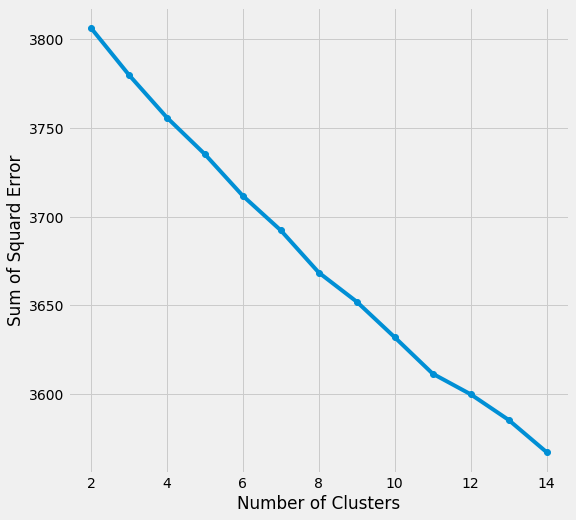

In [48]:
# Plot sse against n_clusters in elbow method
plt.figure(figsize=(8, 8))
plt.plot(list(test_range), sse, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squard Error');

In [49]:
# Normalization for tdidf values. If we don't handle this, the unitprice attributes will dominant the similiarity
tfidf_norm = (tfidf_df-tfidf_df.min())/(tfidf_df.max()-tfidf_df.min())

In [50]:
# Create UnitPrice dummy attributes
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    tfidf_norm.loc[:, col] = 0

for i, prod in enumerate(corpus):
    prix = df[ df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    tfidf_norm.loc[i, label_col[j-1]] = 1

In [51]:
# Check the UnitPrice dummy if correct
display(tfidf_norm.head(10))

,10,11,12,120cm,125g,15,15c,15cm,16,16x16cm,17080,18pc,20,200,20light,...,wrap,wrapping,wreath,wrecking,writing,xmas,yellow,yuletide,zinc,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0


Clusters = 2 the silhouette score = 0.06538186
Clusters = 3 the silhouette score = 0.09724077
Clusters = 4 the silhouette score = 0.12016327
Clusters = 5 the silhouette score = 0.13815728
Clusters = 6 the silhouette score = 0.14685255
Clusters = 7 the silhouette score = 0.11154676
Clusters = 8 the silhouette score = 0.08774961
Clusters = 9 the silhouette score = 0.10091512
Clusters = 10 the silhouette score = 0.08860039
Clusters = 11 the silhouette score = 0.05895337
Clusters = 12 the silhouette score = 0.05755015
Clusters = 13 the silhouette score = 0.0426391
Clusters = 14 the silhouette score = 0.06732155


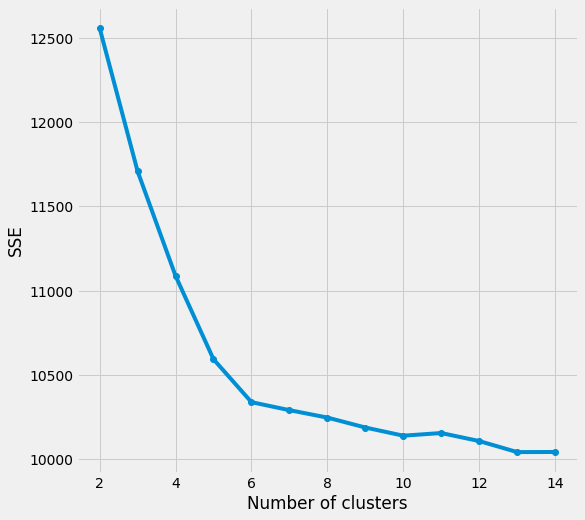

In [52]:
matrix = tfidf_norm.values
sse=[]
for n_clusters in test_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    sse.append(kmeans.inertia_)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))
    

# Plot sse against n_clusters
plt.figure(figsize=(8, 8))
plt.plot(list(test_range), sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE');

In [53]:
# I think this orginal purpose for part is just make sue 
# the model for word cloud can be close to or better the model we did above.
# By controling the silhouette_score can make sure the result as we expect.
n_clusters = 6
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))

Clusters = 6 the silhouette score = 0.14685255


In [54]:
# Check clusters distribution 
pd.Series(clusters).value_counts()

2    1008
1     964
5     672
0     606
4     470
3     155
dtype: int64

In [55]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

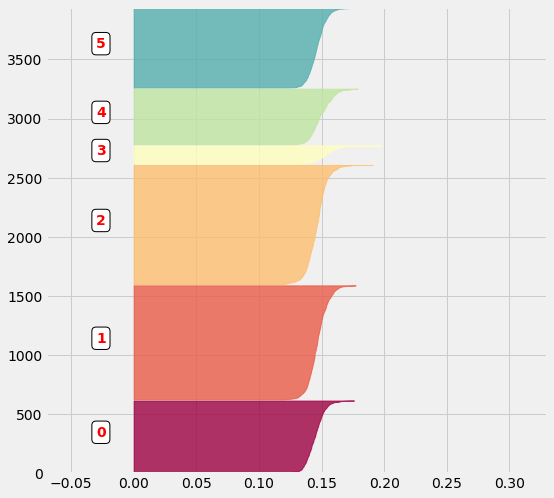

In [56]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(tfidf_df), sample_silhouette_values, clusters)

In [57]:
# Plot word cloud
d_list = df['Description'].unique().tolist()
prod_cluster = defaultdict(list)
for i in range(len(clusters)):
    cluster_num = clusters[i]
    prod_cluster[cluster_num].append(d_list[i])
'''
for i in range(len(prod_cluster)):
    s = " "
    words = s.join(prod_cluster[i])
    wordcloud = WordCloud().generate(text = words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('cluster {}'.format(i))
    plt.show()
'''

'\nfor i in range(len(prod_cluster)):\n    s = " "\n    words = s.join(prod_cluster[i])\n    wordcloud = WordCloud().generate(text = words)\n    plt.imshow(wordcloud, interpolation=\'bilinear\')\n    plt.axis("off")\n    plt.title(\'cluster {}\'.format(i))\n    plt.show()\n'

In [58]:
#RFM-Recency: how long since the last purchase of a customer in days
df["lenOfPurchase"] = df["Date"].max()-df["Date"]
df["lenOfPurchase"] = df["lenOfPurchase"].map(lambda x: x.days)
df["Recency"] = df["CustomerID"].map(df.groupby("CustomerID")["lenOfPurchase"].min().to_dict().get)

#RFM-Monetary: the total amount that one customer spent on all purchases
df["Monetary"] = df["CustomerID"].map(df.groupby("CustomerID")["Amount"].sum().to_dict().get)

#RFM-Frequency: how many orders one customer placed in terms of unique invoice#
df["Frequency"] = df["CustomerID"].map(df.groupby("CustomerID")["InvoiceNo"].nunique().to_dict().get)

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount,Holiday,lenOfPurchase,Recency,Monetary,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,Non-Holiday,373,372,5391.21,34
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,Non-Holiday,373,372,5391.21,34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,Non-Holiday,373,372,5391.21,34


In [59]:
# Add product category entry in major df
prod_cluster_inv = {}
for k,v in prod_cluster.items():
    for i in v:
        prod_cluster_inv[i] = k

df["ProdCate"] = df["Description"].map(prod_cluster_inv.get)

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount,Holiday,lenOfPurchase,Recency,Monetary,Frequency,ProdCate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,Non-Holiday,373,372,5391.21,34,5
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,Non-Holiday,373,372,5391.21,34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,Non-Holiday,373,372,5391.21,34,0


In [60]:
# Add spending for each product category
for i in range(6):
    cate = "cate_" + str(i)
    current_cate_amount = df[df["ProdCate"]==i]["Amount"]
    current_cate_amount = current_cate_amount
    df.loc[:, cate] = current_cate_amount

df = df.fillna(0)

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount,Holiday,lenOfPurchase,Recency,Monetary,Frequency,ProdCate,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,Non-Holiday,373,372,5391.21,34,5,0.00,0.0,0.0,0.0,0.0,15.3
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,Non-Holiday,373,372,5391.21,34,0,20.34,0.0,0.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,Non-Holiday,373,372,5391.21,34,0,22.00,0.0,0.0,0.0,0.0,0.0


In [61]:
# type transformation
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['CustomerID'] = df['CustomerID'].astype('float').astype('int').astype('str')

In [62]:
#customer cluster
customer_spent = df.groupby(["CustomerID", "InvoiceNo"], as_index=False)["Amount"].sum()

for i in range(6):
    cate = "cate_"+str(i)
    customer_invoice_spending = df.groupby(["CustomerID", "InvoiceNo"], as_index=False)[cate].sum()
    customer_spent.loc[:, cate] = customer_invoice_spending
customer_spent = customer_spent.groupby('CustomerID',as_index=False).sum()    
customer_spent.head(3)

,CustomerID,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,12347,4310.00,1273.19,484.32,1136.80,191.25,327.74,896.70
1,12348,1797.24,0.00,683.24,754.00,360.00,0.00,0.00
2,12349,1757.55,188.30,79.32,465.86,450.50,358.35,215.22


In [92]:
# Customer Segementation on RFM model
customers_rfm = pd.DataFrame()
customers_rfm['CustomerID'] = df['CustomerID'].unique()
customers_rfm["Frequency"] = customers_rfm["CustomerID"].map(df.groupby("CustomerID")["InvoiceNo"].nunique().to_dict().get)
customers_rfm['Recency'] = customers_rfm['CustomerID'].map((df['Date'].max()-df.groupby('CustomerID')['Date'].max()).to_dict().get)
customers_rfm = pd.merge(customers_rfm,customer_spent,on='CustomerID')
customers_rfm['Recency'] = customers_rfm['Recency'].dt.days
customers_rfm.head(10)

,CustomerID,Frequency,Recency,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,17850,34,372,5391.21,1878.04,0.00,594.12,607.75,1262.80,1048.50
1,13047,10,31,3237.54,956.90,277.18,494.78,145.75,826.45,536.48
2,12583,15,2,7281.38,2082.10,1448.88,1532.50,806.25,245.25,1166.40
3,13748,5,95,948.25,48.20,52.68,147.00,93.65,29.40,577.32
4,15100,3,333,876.00,0.00,0.00,0.00,876.00,0.00,0.00
5,15291,15,25,4668.30,784.60,207.48,978.46,224.05,1972.95,500.76
6,14688,21,7,5579.10,964.60,900.10,1140.47,25.00,428.85,2120.08
7,17809,12,16,5411.91,1425.49,127.38,1232.89,0.00,1843.15,783.00
8,15311,91,0,60632.75,5879.91,4780.97,18800.67,755.00,7703.65,22712.55
9,16098,7,87,2005.63,404.00,45.67,93.30,528.20,382.50,551.96


In [93]:
# Save unnormalized customer RFM information
ori_customer_rfm = customers_rfm.drop(columns=["Recency"]).copy()
ori_customer_rfm["Amount per Visit"] = customers_rfm['Amount']/customers_rfm['Frequency']
display(ori_customer_rfm.head(5))

,CustomerID,Frequency,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5,Amount per Visit
0,17850,34,5391.21,1878.04,0.00,594.12,607.75,1262.80,1048.50,158.565000
1,13047,10,3237.54,956.90,277.18,494.78,145.75,826.45,536.48,323.754000
2,12583,15,7281.38,2082.10,1448.88,1532.50,806.25,245.25,1166.40,485.425333
3,13748,5,948.25,48.20,52.68,147.00,93.65,29.40,577.32,189.650000
4,15100,3,876.00,0.00,0.00,0.00,876.00,0.00,0.00,292.000000


In [94]:
# Normalization RFM dataframe
col = ['Frequency','Recency','cate_0','cate_1','cate_2','cate_3','cate_4','cate_5']
norm = (customers_rfm[col]-customers_rfm[col].min())/(customers_rfm[col].max()-customers_rfm[col].min())
customers_rfm[col] = norm[col]
customers_rfm.head(10)

,CustomerID,Frequency,Recency,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,17850,0.158654,0.997319,5391.21,0.044882,0.000000,0.005971,0.015340,0.007820,0.015152
1,13047,0.043269,0.083110,3237.54,0.022868,0.007918,0.004972,0.003679,0.005118,0.007753
2,12583,0.067308,0.005362,7281.38,0.049759,0.041387,0.015401,0.020350,0.001519,0.016855
3,13748,0.019231,0.254692,948.25,0.001152,0.001505,0.001477,0.002364,0.000182,0.008343
4,15100,0.009615,0.892761,876.00,0.000000,0.000000,0.000000,0.022110,0.000000,0.000000
5,15291,0.067308,0.067024,4668.30,0.018751,0.005927,0.009833,0.005655,0.012218,0.007236
6,14688,0.096154,0.018767,5579.10,0.023052,0.025711,0.011461,0.000631,0.002656,0.030637
7,17809,0.052885,0.042895,5411.91,0.034067,0.003639,0.012390,0.000000,0.011414,0.011315
8,15311,0.432692,0.000000,60632.75,0.140521,0.136567,0.188937,0.019056,0.047705,0.328213
9,16098,0.028846,0.233244,2005.63,0.009655,0.001305,0.000938,0.013332,0.002369,0.007976


In [95]:
train = customers_rfm.drop(['CustomerID','Amount'],axis=1) 
train.head(10)

,Frequency,Recency,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,0.158654,0.997319,0.044882,0.000000,0.005971,0.015340,0.007820,0.015152
1,0.043269,0.083110,0.022868,0.007918,0.004972,0.003679,0.005118,0.007753
2,0.067308,0.005362,0.049759,0.041387,0.015401,0.020350,0.001519,0.016855
3,0.019231,0.254692,0.001152,0.001505,0.001477,0.002364,0.000182,0.008343
4,0.009615,0.892761,0.000000,0.000000,0.000000,0.022110,0.000000,0.000000
5,0.067308,0.067024,0.018751,0.005927,0.009833,0.005655,0.012218,0.007236
6,0.096154,0.018767,0.023052,0.025711,0.011461,0.000631,0.002656,0.030637
7,0.052885,0.042895,0.034067,0.003639,0.012390,0.000000,0.011414,0.011315
8,0.432692,0.000000,0.140521,0.136567,0.188937,0.019056,0.047705,0.328213
9,0.028846,0.233244,0.009655,0.001305,0.000938,0.013332,0.002369,0.007976


In [100]:
# Running k-means clustering after deciding the number of clusters to be 6
matrix = train.values
n_clusters = 6
silhouette_avg = -1
while silhouette_avg < 0.538:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=100)
    kmeans.fit(matrix)
    labels = kmeans.predict(matrix)
    ori_customer_rfm["cluster"] = labels
    customers_rfm["cluster"] = labels
    silhouette_avg = silhouette_score(matrix, labels)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))
display(customers_rfm.head(5))
display(ori_customer_rfm.head(5))

Clusters = 6 the silhouette score = 0.54053942


,CustomerID,Frequency,Recency,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5,cluster
0,17850,0.158654,0.997319,5391.21,0.044882,0.000000,0.005971,0.015340,0.007820,0.015152,1
1,13047,0.043269,0.083110,3237.54,0.022868,0.007918,0.004972,0.003679,0.005118,0.007753,0
2,12583,0.067308,0.005362,7281.38,0.049759,0.041387,0.015401,0.020350,0.001519,0.016855,0
3,13748,0.019231,0.254692,948.25,0.001152,0.001505,0.001477,0.002364,0.000182,0.008343,4
4,15100,0.009615,0.892761,876.00,0.000000,0.000000,0.000000,0.022110,0.000000,0.000000,1


,CustomerID,Frequency,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5,Amount per Visit,cluster
0,17850,34,5391.21,1878.04,0.00,594.12,607.75,1262.80,1048.50,158.565000,1
1,13047,10,3237.54,956.90,277.18,494.78,145.75,826.45,536.48,323.754000,0
2,12583,15,7281.38,2082.10,1448.88,1532.50,806.25,245.25,1166.40,485.425333,0
3,13748,5,948.25,48.20,52.68,147.00,93.65,29.40,577.32,189.650000,4
4,15100,3,876.00,0.00,0.00,0.00,876.00,0.00,0.00,292.000000,1


Below is the interpretation of customer clusters which would be mainly focusing on the general shopping pattern and then the separate shopping pattern corresponding to product categories. We try to summarize our advices for retailors on how to efficiently utilize their resources on attracting customers.

From the columns "Median $ per Visit" and "Median Visit" showed below, all the customer clusters except cluster five have much less spending because they rarely go shopping and usually don't buy much each time they visit a store compared to that of cluster five. This might indicate that either the customer cluster five is doing larger buisness like a wholesaler or they simply have better consuming ability. So, We could first focus on the other five clusters with less spending to see how we can attract them by looking into their level of interests on each product category and also the most interested range of price in each product category. 

In [146]:
# Group by cluster label
customer_cluster = pd.DataFrame()
customer_cluster['Cluster'] = ori_customer_rfm['cluster'].unique()
customer_cluster['Sum $'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["Amount"].sum().to_dict().get)
customer_cluster['Med. $'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["Amount"].median().to_dict().get)
customer_cluster['Size'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["CustomerID"].nunique().to_dict().get)
customer_cluster['Med. Visit'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["Frequency"].median().to_dict().get)
customer_cluster['Median $ per Visit'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["Amount per Visit"].median().to_dict().get)
customer_cluster['Cate0'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_0"].sum().to_dict().get)/customer_cluster['Sum $']*100
customer_cluster['Cate0 Mean'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_0"].mean().to_dict().get)
customer_cluster['Cate0 Std'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_0"].std(ddof=0).to_dict().get)
customer_cluster['Cate1'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_1"].sum().to_dict().get)/customer_cluster['Sum $']*100
customer_cluster['Cate1 Mean'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_1"].mean().to_dict().get)
customer_cluster['Cate1 Std'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_1"].std(ddof=0).to_dict().get)
customer_cluster['Cate2'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_2"].sum().to_dict().get)/customer_cluster['Sum $']*100
customer_cluster['Cate2 Mean'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_2"].mean().to_dict().get)
customer_cluster['Cate2 Std'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_2"].std(ddof=0).to_dict().get)
customer_cluster['Cate3'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_3"].sum().to_dict().get)/customer_cluster['Sum $']*100
customer_cluster['Cate3 Mean'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_3"].mean().to_dict().get)
customer_cluster['Cate3 Std'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_3"].std(ddof=0).to_dict().get)
customer_cluster['Cate4'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_4"].sum().to_dict().get)/customer_cluster['Sum $']*100
customer_cluster['Cate4 Mean'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_4"].mean().to_dict().get)
customer_cluster['Cate4 Std'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_4"].std(ddof=0).to_dict().get)
customer_cluster['Cate5'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_5"].sum().to_dict().get)/customer_cluster['Sum $']*100
customer_cluster['Cate5 Mean'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_5"].mean().to_dict().get)
customer_cluster['Cate5 Std'] = customer_cluster["Cluster"].map(ori_customer_rfm.groupby("cluster")["cate_5"].std(ddof=0).to_dict().get)
customer_cluster.set_index('Cluster', inplace=True)
display(customer_cluster)

,Sum $,Med. $,Size,Med. Visit,Median $ per Visit,Cate0,Cate0 Mean,Cate0 Std,Cate1,Cate1 Mean,Cate1 Std,Cate2,Cate2 Mean,Cate2 Std,Cate3,Cate3 Mean,Cate3 Std,Cate4,Cate4 Mean,Cate4 Std,Cate5,Cate5 Mean,Cate5 Std
Cluster,,,,,,,,,,,,,,,,,,,,,,,
1,109510.170,252.420,289,1,216.070000,19.617100,74.334671,168.263382,9.903491,37.527093,57.852403,20.353717,77.125917,99.446881,11.112338,42.107751,105.428272,19.153262,72.577059,155.508551,19.860092,75.255433,120.011012
0,4854317.271,1194.730,2039,4,298.955000,18.375566,437.473399,938.643149,11.550361,274.983409,501.165353,23.862646,568.106209,888.088204,7.207099,171.581883,534.255919,14.997436,357.049117,871.053527,24.006891,571.540299,1180.671577
4,1081318.522,641.950,1040,2,316.126500,17.841776,185.506183,354.381408,12.953133,134.677520,217.287565,24.739776,257.226712,337.806373,8.351768,86.835780,435.246111,13.851325,144.016288,282.076777,22.262223,231.466865,427.320317
5,1732954.980,64977.175,18,52,1625.755777,17.002445,16369.150556,12134.954349,9.245231,8900.871667,8002.621311,20.693033,19922.274444,20933.332929,8.767640,8441.070000,9230.498666,18.901003,18196.993333,35146.346526,25.390648,24444.916667,16492.963218
3,211771.001,309.440,438,1,234.312500,14.902276,72.051826,155.746625,11.799798,57.051486,133.861429,22.829703,110.380571,156.300585,9.487805,45.873105,99.450685,18.359487,88.767283,207.297314,22.620930,109.371164,275.234977
2,374002.460,408.360,505,2,246.983333,13.789158,102.122356,201.701220,12.409450,91.904257,151.407550,22.564416,167.111822,223.778168,19.720587,146.050455,1780.146562,13.803773,102.230594,157.397300,17.712616,131.179446,193.727916


Columns cate0 to cate5 are the proportion out of the total amount of money they spend. So, from these columns and also the radar chart below, we can prioritize product categories for recommending customers. For example, we can first focus attracting customer cluster 1 by promoting more on product category 2 because they tend to buy more on that. In next step, we can research on what would be the most attractive range of price of the products that the customers would more likely to buy.

In [147]:
# Create Radar Chart for each customer cluster
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid(False)
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

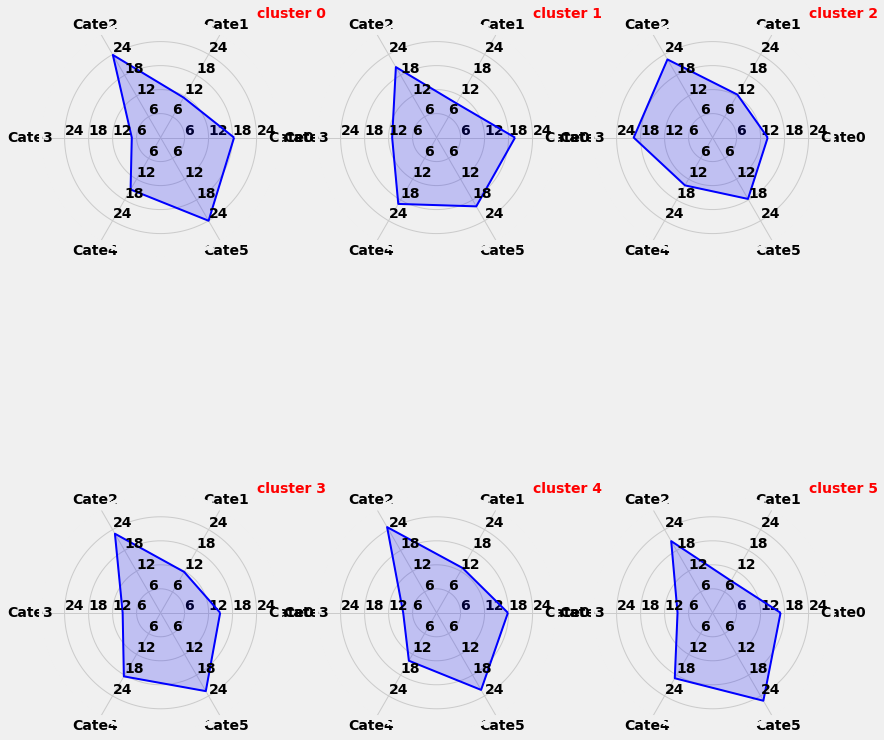

In [148]:
fig = plt.figure(figsize=(10,12))
attributes = ['Cate0', 'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5']
ranges = [[0.01, 30], [0.01, 30], [0.01, 30], [0.01, 30], [0.01, 30], [0.01, 30]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(customer_cluster.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster {}'.format(index[ind]), color = 'r')
    ind += 1 

To dive into the majority interests of clusters, we can take a look on how most of the people in the cluster usually buy. Here we calculate mean and standard deviation of the amount of money each cluster spend on each product category, so we know what's the normal amount of money they would spend in it. For example, we can advise the retailers to advertise more on products category 2 priced between 0 and 177 (the value of mean plus 1 standard deviation) for customer cluster 1. This observation is also visualized below as pie charts

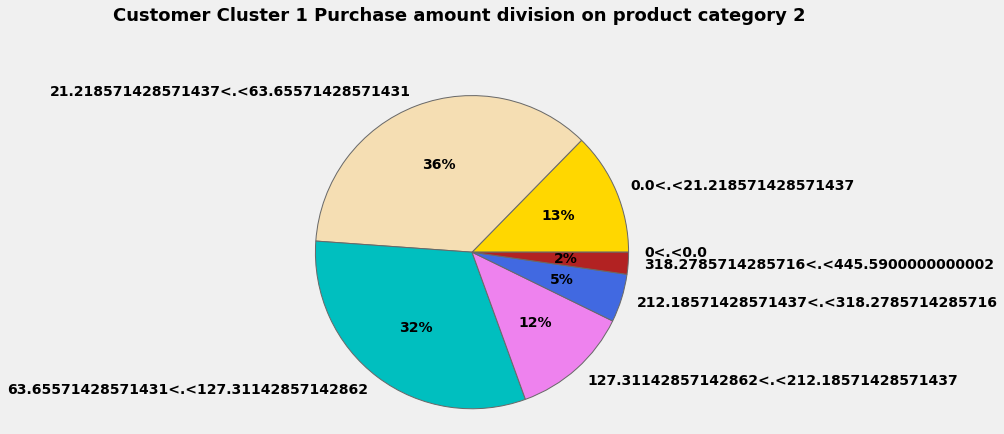

In [152]:
# Purchases division
amount_max = ori_customer_rfm[ori_customer_rfm["cluster"]==1]["cate_2"].max()
amount_min = ori_customer_rfm[ori_customer_rfm["cluster"]==1]["cate_2"].min()
unit = (amount_max - amount_min) / 28
current_threshold = 0
#price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
price_range = []
for i in range(8):
    price_range.append(current_threshold)
    current_threshold = current_threshold + i*unit
count_price = []
basket_price = ori_customer_rfm[ori_customer_rfm['cluster']==1].copy()
#display(basket_price.head(5))
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['cate_2'] < price) &
                       (basket_price['cate_2'] > price_range[i-1])]['cate_2'].count()
    count_price.append(val)
# visualize the purchase division for a cumster cluster to a product category        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Customer Cluster 1 Purchase amount division on product category 2", ha='center', fontsize = 18);